In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
import shap
import pickle

In [2]:
# Load and split data
df = pd.read_csv('heart.csv')

In [24]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [25]:
df.shape

(1025, 14)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [27]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [3]:
# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=0)
X_train, y_train = smote.fit_resample(X_train, y_train)

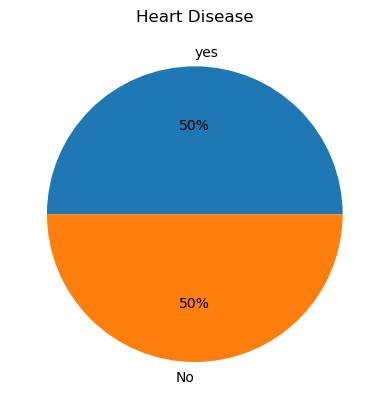

In [28]:
# Create a plot to display the percentage of the positive and negative heart disease 
labels = ['yes', 'No']
values = y_train.value_counts().values

plt.pie(values, labels=labels, autopct='%1.0f%%')
plt.title('Heart Disease')
plt.show()

In [4]:
# Define models and parameter distributions
models = {
    'RandomForest': RandomForestClassifier(random_state=1),
    'AdaBoost': AdaBoostClassifier(random_state=1),
    'GradientBoosting': GradientBoostingClassifier(random_state=1),
    'XGBoost': XGBClassifier(random_state=1, eval_metric='logloss'),
    'MLP': MLPClassifier(random_state=1)
}

param_dist = {
    'RandomForest': {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    },
    'AdaBoost': {
        'n_estimators': [50, 100, 200, 300, 400, 500],
        'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0]
    },
    'GradientBoosting': {
        'n_estimators': [100, 200, 300, 400, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 4, 5, 6],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300, 400, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 4, 5, 6],
        'min_child_weight': [1, 3, 5, 7],
        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
    },
    'MLP': {
        'hidden_layer_sizes': [(10,), (50,), (100,), (50, 50), (100, 50)],
        'activation': ['tanh', 'relu'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001, 0.01, 0.1],
        'learning_rate': ['constant', 'adaptive'],
        'learning_rate_init': [0.001, 0.01, 0.1]
    }
}

# Hyperparameter tuning with RandomizedSearchCV
best_models = {}
for name, model in models.items():
    random_search = RandomizedSearchCV(model, param_dist[name], n_iter=20, cv=5, scoring='roc_auc', random_state=1, n_jobs=-1)
    random_search.fit(X_train, y_train)
    best_models[name] = random_search.best_estimator_

# Evaluate models
results = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)
    positive_rate = sum(y_pred) / len(y_pred)
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1_score': f1_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_prob),
        'positive_rate': positive_rate,
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

# Create and display a table with all metrics
metrics_table = pd.DataFrame(results).T
print("Model Performance Metrics:")
print(metrics_table.drop(columns='confusion_matrix'))

Model Performance Metrics:
                  accuracy precision    recall  f1_score   roc_auc  \
RandomForest           1.0       1.0       1.0       1.0       1.0   
AdaBoost          0.980488  0.972477  0.990654  0.981481  0.998093   
GradientBoosting       1.0       1.0       1.0       1.0       1.0   
XGBoost                1.0       1.0       1.0       1.0       1.0   
MLP               0.917073  0.881356  0.971963  0.924444  0.975968   

                 positive_rate  
RandomForest          0.521951  
AdaBoost              0.531707  
GradientBoosting      0.521951  
XGBoost               0.521951  
MLP                    0.57561  


In [29]:
from sklearn.metrics import confusion_matrix

# Function to extract confusion matrix values
def extract_confusion_matrix(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {'True Positive': tp, 'True Negative': tn, 'False Positive': fp, 'False Negative': fn}

# Create a list to store confusion matrix values
conf_matrix_results = []

for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    cm_values = extract_confusion_matrix(y_test, y_pred)
    cm_values['Model'] = model_name
    conf_matrix_results.append(cm_values)

# Convert to DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix_results)

# Reorder columns for clarity
conf_matrix_df = conf_matrix_df[['Model', 'True Positive', 'True Negative', 'False Positive', 'False Negative']]

# Display the confusion matrix table
print("\nConfusion Matrix for All Models:\n")
print(conf_matrix_df)


Confusion Matrix for All Models:

              Model  True Positive  True Negative  False Positive  \
0      RandomForest            107             98               0   
1          AdaBoost            106             95               3   
2  GradientBoosting            107             98               0   
3           XGBoost            107             98               0   
4               MLP            104             84              14   

   False Negative  
0               0  
1               1  
2               0  
3               0  
4               3  


In [30]:
conf_matrix_df

,Model,True Positive,True Negative,False Positive,False Negative
0,RandomForest,107,98,0,0
1,AdaBoost,106,95,3,1
2,GradientBoosting,107,98,0,0
3,XGBoost,107,98,0,0
4,MLP,104,84,14,3


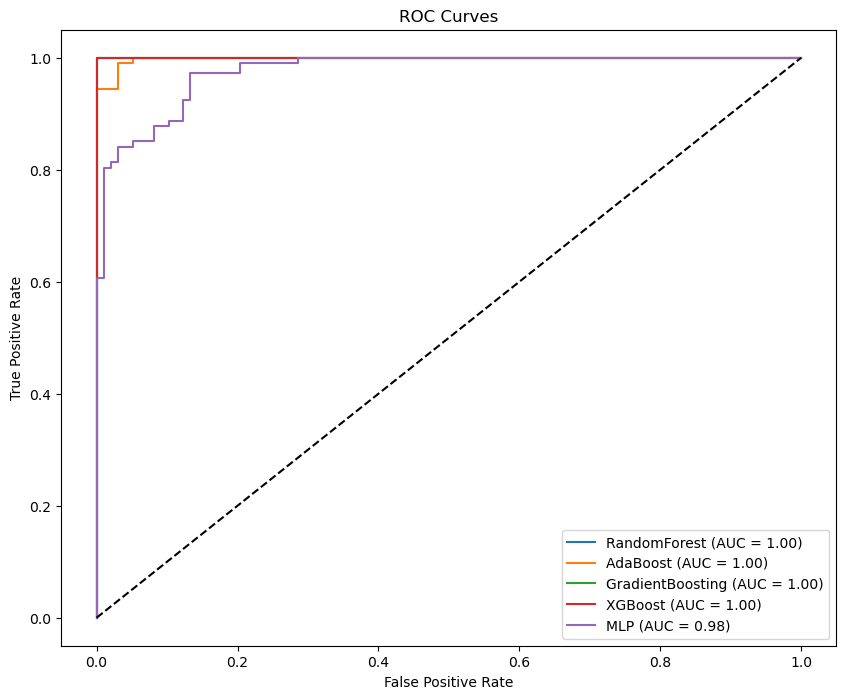

In [5]:
# Plot confusion matrices
for name in results:
    plt.figure()
    sns.heatmap(results[name]['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.savefig(f'{name}_cm.png')
    plt.close()

# Plot ROC curves for all models in one figure
plt.figure(figsize=(10, 8))
for name, model in best_models.items():
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = results[name]['roc_auc']
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.savefig('roc_curves.png')
plt.show()

In [6]:
# Select best model based on ROC-AUC
max_roc_auc = max(results.values(), key=lambda x: x['roc_auc'])['roc_auc']
best_models_list = [name for name, res in results.items() if res['roc_auc'] == max_roc_auc]
if len(best_models_list) > 1:
    print(f"Multiple models achieved the highest ROC-AUC of {max_roc_auc}: {best_models_list}")
    best_model_name = best_models_list[0]
else:
    best_model_name = best_models_list[0]
best_model = best_models[best_model_name]
print(f"Selected best model: {best_model_name}")

Multiple models achieved the highest ROC-AUC of 1.0: ['RandomForest', 'GradientBoosting', 'XGBoost']
Selected best model: RandomForest


In [7]:
# Fairness analysis: Sex
PROTECTED = "sex"
MEN = 1
WOMEN = 0
gender_dist = X_test[PROTECTED].value_counts()
print("Gender Distribution in Test Set:")
print(gender_dist)
men_indices = np.where(X_test[PROTECTED] == MEN)[0]
women_indices = np.where(X_test[PROTECTED] == WOMEN)[0]
print("Men indices:", men_indices, "No of Men =", men_indices.size)
print("Women indices:", women_indices, "No of Women =", women_indices.size)

Gender Distribution in Test Set:
sex
1    136
0     69
Name: count, dtype: int64
Men indices: [  0   2   3   4   5   6   8   9  10  11  12  13  14  17  19  20  21  22
  23  27  32  34  35  38  39  40  41  44  47  48  49  50  51  52  53  54
  55  56  58  60  63  65  66  70  74  75  77  79  80  81  85  89  90  91
  92  93  95  96  97  98  99 100 103 104 105 106 108 109 110 112 113 114
 115 117 118 120 121 122 123 124 125 127 129 130 131 132 133 134 135 136
 137 139 140 142 143 145 147 148 149 150 151 152 153 154 155 156 157 159
 160 161 162 163 165 167 170 171 173 175 176 177 179 181 182 183 184 185
 187 188 189 190 192 193 194 195 197 198] No of Men = 136
Women indices: [  1   7  15  16  18  24  25  26  28  29  30  31  33  36  37  42  43  45
  46  57  59  61  62  64  67  68  69  71  72  73  76  78  82  83  84  86
  87  88  94 101 102 107 111 116 119 126 128 138 141 144 146 158 164 166
 168 169 172 174 178 180 186 191 196 199 200 201 202 203 204] No of Women = 69


In [8]:
# Predictions for men and women
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, 'predict_proba') else best_model.decision_function(X_test)
y_test_men = y_test.iloc[men_indices]
y_test_women = y_test.iloc[women_indices]
y_pred_men = [y_pred[i] for i in men_indices]
y_pred_women = [y_pred[i] for i in women_indices]
y_prob_men = [y_prob[i] for i in men_indices]
y_prob_women = [y_prob[i] for i in women_indices]

# Metrics for men
cm_male = confusion_matrix(y_test_men, y_pred_men)
tn, fp, fn, tp = cm_male.ravel()
print("\nMale Confusion Matrix Metrics:")
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
disp = sns.heatmap(cm_male, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Men')
plt.savefig('cm_male.png')
plt.close()
accuracy_men = accuracy_score(y_test_men, y_pred_men)
recall_men = recall_score(y_test_men, y_pred_men, zero_division=0)
precision_men = precision_score(y_test_men, y_pred_men, zero_division=0)
positive_rate_men = sum(y_pred_men) / len(y_pred_men)
f1_men = f1_score(y_test_men, y_pred_men, zero_division=0)
roc_auc_men = roc_auc_score(y_test_men, y_prob_men)
print(f"Men: Accuracy={accuracy_men:.2f}, Recall={recall_men:.2f}, Precision={precision_men:.2f}, Positive Rate={positive_rate_men:.2f}, F1={f1_men:.2f}, ROC-AUC={roc_auc_men:.2f}")

# Metrics for women
cm_female = confusion_matrix(y_test_women, y_pred_women)
tn, fp, fn, tp = cm_female.ravel()
print("\nFemale Confusion Matrix Metrics:")
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
disp = sns.heatmap(cm_female, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Women')
plt.savefig('cm_female.png')
plt.close()
accuracy_women = accuracy_score(y_test_women, y_pred_women)
recall_women = recall_score(y_test_women, y_pred_women, zero_division=0)
precision_women = precision_score(y_test_women, y_pred_women, zero_division=0)
positive_rate_women = sum(y_pred_women) / len(y_pred_women)
f1_women = f1_score(y_test_women, y_pred_women, zero_division=0)
roc_auc_women = roc_auc_score(y_test_women, y_prob_women)
print(f"Women: Accuracy={accuracy_women:.2f}, Recall={recall_women:.2f}, Precision={precision_women:.2f}, Positive Rate={positive_rate_women:.2f}, F1={f1_women:.2f}, ROC-AUC={roc_auc_women:.2f}")

# ROC curve for male and female
fpr_men, tpr_men, _ = roc_curve(y_test_men, y_prob_men)
fpr_women, tpr_women, _ = roc_curve(y_test_women, y_prob_women)
plt.figure(figsize=(8, 6))
plt.plot(fpr_men, tpr_men, label=f'Men (ROC AUC = {roc_auc_men:.2f})')
plt.plot(fpr_women, tpr_women, label=f'Women (ROC AUC = {roc_auc_women:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Male and Female')
plt.legend()
plt.savefig('roc_sex.png')
plt.close()

print("\nROC AUC Score for Male:", roc_auc_men)
print("ROC AUC Score for Female:", roc_auc_women)


Male Confusion Matrix Metrics:
TN=77, FP=0, FN=0, TP=59
Men: Accuracy=1.00, Recall=1.00, Precision=1.00, Positive Rate=0.43, F1=1.00, ROC-AUC=1.00

Female Confusion Matrix Metrics:
TN=21, FP=0, FN=0, TP=48
Women: Accuracy=1.00, Recall=1.00, Precision=1.00, Positive Rate=0.70, F1=1.00, ROC-AUC=1.00

ROC AUC Score for Male: 1.0
ROC AUC Score for Female: 1.0


In [9]:
# Fairness analysis: Age
def categorize_age(age):
    if age < 40:
        return 'young'
    elif 40 <= age < 60:
        return 'adult'
    else:
        return 'old'

X_test_with_age_group = X_test.copy()
X_test_with_age_group['age_group'] = X_test_with_age_group['age'].apply(categorize_age)
age_groups = ['young', 'adult', 'old']
print("\nFairness Metrics by Age Group:")
for group in age_groups:
    indices = X_test_with_age_group[X_test_with_age_group['age_group'] == group].index
    y_test_group = y_test.loc[indices]
    X_test_group = X_test.loc[indices]  # Use original X_test without age_group
    y_pred_group = best_model.predict(X_test_group)
    y_prob_group = best_model.predict_proba(X_test_group)[:, 1] if hasattr(best_model, 'predict_proba') else best_model.decision_function(X_test_group)
    accuracy = accuracy_score(y_test_group, y_pred_group)
    precision = precision_score(y_test_group, y_pred_group, zero_division=0)
    recall = recall_score(y_test_group, y_pred_group, zero_division=0)
    f1 = f1_score(y_test_group, y_pred_group, zero_division=0)
    roc_auc = roc_auc_score(y_test_group, y_prob_group)
    positive_rate = sum(y_pred_group) / len(y_pred_group)
    print(f"Age group {group}: Accuracy={accuracy:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, F1={f1:.2f}, ROC-AUC={roc_auc:.2f}, Positive Rate={positive_rate:.2f}")


Fairness Metrics by Age Group:
Age group young: Accuracy=1.00, Precision=1.00, Recall=1.00, F1=1.00, ROC-AUC=1.00, Positive Rate=0.91
Age group adult: Accuracy=1.00, Precision=1.00, Recall=1.00, F1=1.00, ROC-AUC=1.00, Positive Rate=0.55
Age group old: Accuracy=1.00, Precision=1.00, Recall=1.00, F1=1.00, ROC-AUC=1.00, Positive Rate=0.36


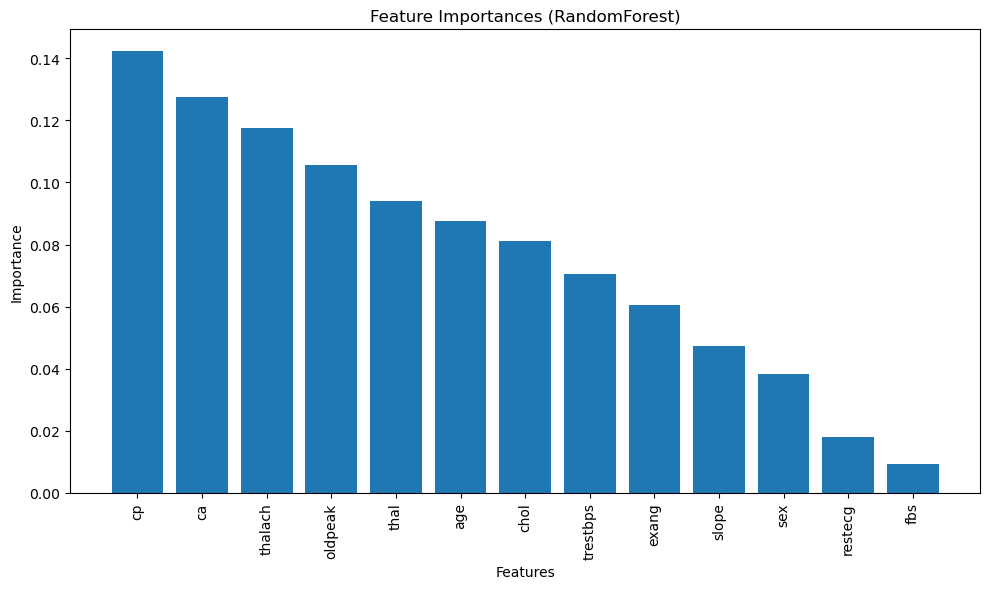

In [10]:
# Feature Importance for the best model
if best_model_name in ['RandomForest', 'GradientBoosting', 'XGBoost']:
    importances = best_model.feature_importances_
    feature_names = X_test.columns
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importances ({best_model_name})")
    plt.bar(range(len(importances)), importances[indices], align="center")
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

Length of shap_values: 205
Shape of shap_values: (205, 13, 2)
Shape of shap_values_class1: (205, 13)


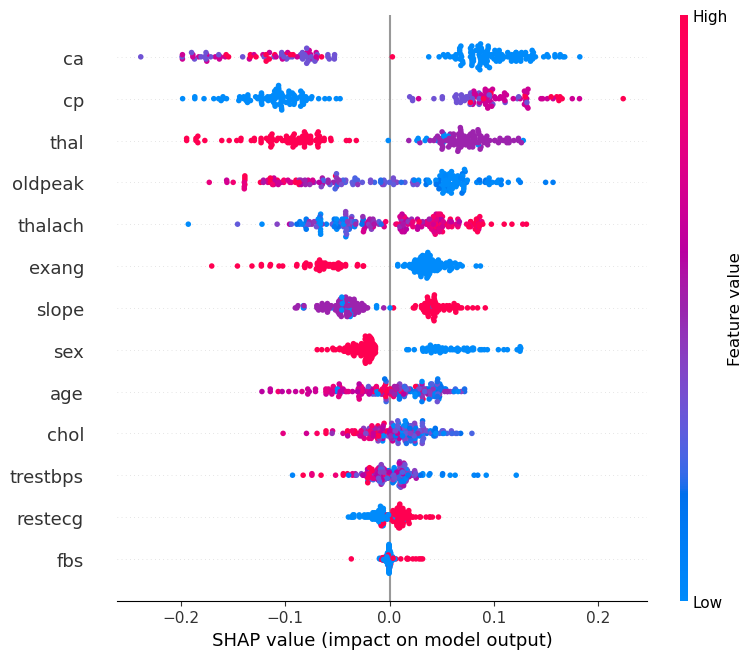

Type of single_shap_values: <class 'numpy.ndarray'>
Shape of single_shap_values: (1, 13, 2)
Shape of values for waterfall plot: (13,)
Base value: 0.49794351630867123


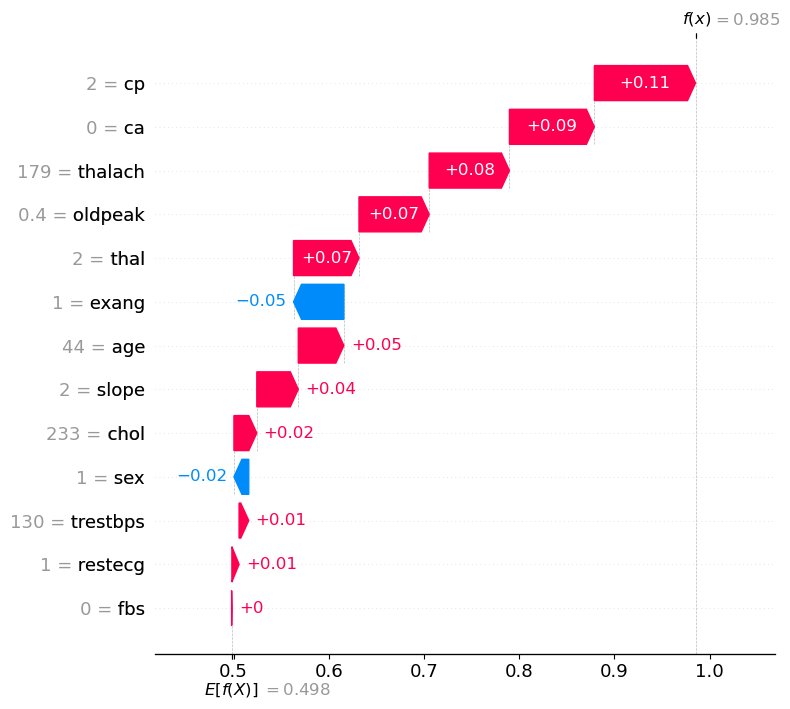

In [18]:
# SHAP analysis
if best_model_name in ['RandomForest', 'GradientBoosting', 'XGBoost']:
    explainer = shap.TreeExplainer(best_model)
else:
    explainer = shap.KernelExplainer(best_model.predict, X_train)

# Compute SHAP values for the entire test set
shap_values = explainer.shap_values(X_test)
print("Length of shap_values:", len(shap_values))
print("Shape of shap_values:", shap_values.shape if isinstance(shap_values, np.ndarray) else len(shap_values))

# For binary classification, use class 1 (positive class) for explanation
# If shap_values is 3D (samples, features, classes), select class 1
if isinstance(shap_values, np.ndarray) and len(shap_values.shape) == 3:
    shap_values_class1 = shap_values[:, :, 1]  # All samples, all features, class 1
else:
    shap_values_class1 = shap_values[1] if isinstance(shap_values, list) else shap_values
print("Shape of shap_values_class1:", shap_values_class1.shape)

# SHAP summary plot (show all features)
shap.summary_plot(shap_values_class1, X_test, max_display=13, show=False)
plt.savefig('shap_summary.png')
plt.show()

# Compute SHAP values for the first instance
single_shap_values = explainer.shap_values(X_test.iloc[0:1])
print("Type of single_shap_values:", type(single_shap_values))
print("Shape of single_shap_values:", single_shap_values.shape if isinstance(single_shap_values, np.ndarray) else len(single_shap_values))

# Handle single instance SHAP values
if isinstance(single_shap_values, np.ndarray) and len(single_shap_values.shape) == 3:
    values = single_shap_values[0, :, 1]  # First sample, all features, class 1
else:
    values = single_shap_values[0] if isinstance(single_shap_values, list) else single_shap_values[0]
print("Shape of values for waterfall plot:", values.shape)

# Ensure base_value is a scalar
base_value = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value
if isinstance(base_value, (list, np.ndarray)):
    base_value = float(base_value[0]) if len(base_value) == 1 else float(base_value)
print("Base value:", base_value)

# SHAP waterfall plot for the first instance
shap.waterfall_plot(
    shap.Explanation(values=values, base_values=base_value, data=X_test.iloc[0].values, feature_names=X_test.columns),
    max_display=13,
    show=False
)
plt.savefig('shap_force.png')
plt.show()

In [19]:
# Write SHAP explanation to a text file
with open('shap_explanation.txt', 'w') as f:
    f.write("SHAP Summary Plot (shap_summary.png):\n")
    f.write("This plot shows the impact of each feature on the model's predictions across all test samples.\n")
    f.write("Features are ranked by importance (top to bottom). Red indicates a positive impact on the prediction, blue indicates a negative impact.\n\n")
    f.write("SHAP Force Plot (shap_force.png):\n")
    f.write("This plot shows the contribution of each feature to the prediction for the first test sample.\n")
    f.write("Features pushing the prediction higher are in red, and those pushing it lower are in blue.\n")

# Save the best model
with open('best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [20]:
X.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

In [21]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (838, 13)
Shape of X_test: (205, 13)


In [22]:
print("Model trained on:", feature_names)  # Use the feature names from training
print("Current dataset:", list(X_train.columns))

Model trained on: Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')
Current dataset: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


In [23]:
X_train.to_csv('X_train.csv', index=False)